## This cell is for a test of the PleiadesModel notebook
### Checking magnitudes in DeltaV vs. (V-K) CMD for a 50% fill factor and temperature contrasts of 0 and 1. Expect to see a 0.75 magnitude difference for all corresponding values for a factor of 2 difference in flux profiles.

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

import HELP
get_model = HELP.get_model
make_spotmodel = HELP.make_spotmodel
Dotter_rad = HELP.Dotter_rad
MagConvert = HELP.MagConvert
V_VKPlotData = HELP.V_VKPlotData
PleiadesDeltaV_VK = HELP.PleiadesDeltaV_VK
CMDData = HELP.CMDData
DeltaVfunc = HELP.DeltaVfunc

import getMag
getMag = getMag.getMag

import getMag_hires
getMag_hires = getMag_hires.getMag_hires

In [2]:
#Open Kamaii isochrone V vs (V-K)

KamaiIsochrone = open('data/Kamai_Isochrone.tbl','r')
names = KamaiIsochrone.readline().split
KamaiIsochrone.close()
KamaiIsochrone = pd.read_table('data/Kamai_Isochrone.tbl',sep=None,engine='python')

KamaiV = [i-5.67 for i in KamaiIsochrone['V']]
KamaiVK = KamaiIsochrone['V - K']

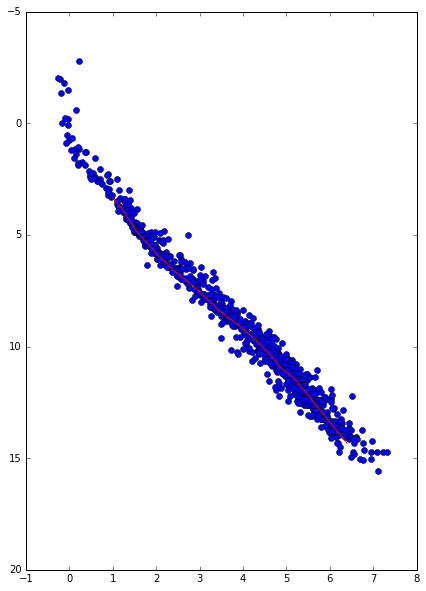

In [3]:
#Testing a new general function to grab Pleiades magnitudes

PleiaK,PleiaV = CMDData('K','V')
PleiaVKinit = [i-j for i,j in zip(PleiaV,PleiaK)]

plt.figure(figsize=(7,10))
plt.plot(PleiaVKinit,PleiaV,'o',KamaiVK,KamaiV,'r-')
plt.gca().invert_yaxis()

In [4]:
##TEST CELL FOR 100% AND 0% TEMPERATURE CONTRAST##

PhMax = 7000
PhMin = 2300
SpTempFrac = [1.,0.6,0.5]
FillFactor = 0.4

PhRange = np.arange(PhMax,PhMin,-200)                              #Array of photospheric temperatures to run through
SpRange = [str(int(round(i/100)*100)) for i in PhRange] #List of strings of spot temps as a fraction of PhTemp
PhRange = [str(i) for i in PhRange]

FluxRangeTemp1 = []
for i in range(len(PhRange)):
    wavelength, flux_Phoenix, PhTemp, SpTemp, FillFactor = make_spotmodel(PhRange[i],SpRange[i],FillFactor)
    Flux = Dotter_rad(PhTemp, flux_Phoenix)
    FluxRangeTemp1.append(Flux)

FluxRange = []
FluxRange.append(FluxRangeTemp1)
FluxRangeTemp0 = [i/2 for i in FluxRangeTemp1]
FluxRange.append(FluxRangeTemp0)
    ##FluxRange is a list of two arrays, filled each with flux data for incremental photospheric temperatures
    ##First array is for temperature contrast of 1, i.e. all photospheric temperature
    ##Second array is for temperature contrast of 0, FF of 0.5, i.e. half of the star is blacked out.
        ##Found by dividing all elements of first array by two

In [5]:
PhMax = 7000
PhMin = 4400
SpTempFrac = [1.,0.6,0.5]
FillFactor = 0.4

PhRange = np.arange(PhMax,PhMin,-200)                              #List of photospheric temperatures to run through
SpRange = []
for j in SpTempFrac:
    x = [str(int(round(j*i/100)*100)) for i in PhRange] #List of strings of spot temps as a fraction of PhTemp
    SpRange.append(x)
PhRange = [str(i) for i in PhRange]

FluxRange = []
for i in range(len(SpRange)):
    FluxRangeTemp = []
    for j in range(len(PhRange)):
        Flux = []
        wavelength, flux_Phoenix, PhTemp, SpTemp, FillFactor = make_spotmodel(PhRange[j],SpRange[i][j],FillFactor)
        Flux = Dotter_rad(PhTemp, flux_Phoenix)
        FluxRangeTemp.append(Flux)
    FluxRange.append(FluxRangeTemp)



In [7]:
Vmags = []
VKmags = []
idx=0
for i in range(len(FluxRange)):
    VmagsTemp = []
    for j in range(len(FluxRange[idx])):
        band,center,mag = getMag_hires('V',wavelength,FluxRange[idx][j],'microns')
        VmagsTemp.append(mag)                      #Vmags filled with V magnitudes for photospheric temperatures in specified range
    Vmags.append(VmagsTemp)
    
    KmagsTemp = []
    for j in range(len(FluxRange[idx])):
        band,center,mag = getMag_hires('Ks',wavelength,FluxRange[idx][j],'microns')
        KmagsTemp.append(mag)                     #Kmags filled with K magnitudes for photospheric temperatures in specified range
    
    VKMagsTemp=[]
    VKmagsTemp = [i-j for i,j in zip(VmagsTemp,KmagsTemp)]#VKmags filled with (V-K) colors for photospheric temperatures in specified range
    VKmags.append(VKmagsTemp)
    
    idx+=1

/Users/saethen/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


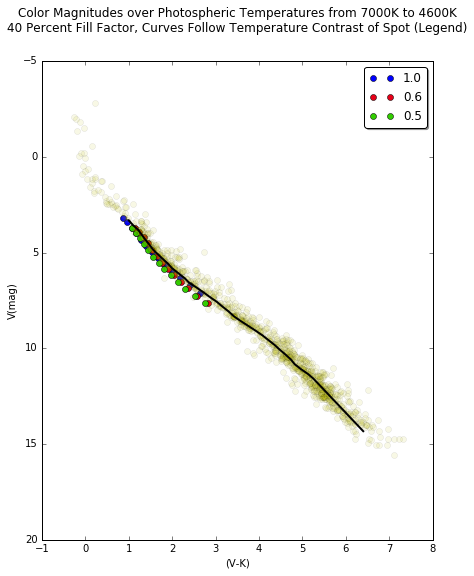

In [24]:
plt.figure(figsize=(7,14))


colormap = plt.cm.brg
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0,0.9,len(SpTempFrac))])
for i in range(len(SpTempFrac)):
    plt.plot(VKmags[i],Vmags[i],'o')
plt.plot(PleiaVKinit,PleiaV,'yo',alpha=0.1)
plt.plot(KamaiVK,KamaiV,'k-',lw=2)

plt.tight_layout
plt.gca().invert_yaxis()
plt.subplots_adjust(top=0.6)

plt.legend(SpTempFrac,fancybox=True,shadow=True)
plt.xlabel('(V-K)')
plt.ylabel('V(mag)')
plt.title('Color Magnitudes over Photospheric Temperatures from 7000K to 4600K\n40 Percent Fill Factor, Curves Follow Temperature Contrast of Spot (Legend)',y=1.05)

In [11]:
def PleiadesDeltaV_VK(x,y):
    '''
    Returns Delta V and (V-K) arrays for Pleiades data with respect to Kamai isochrone. Could be modified to a more general function that inputs more filters, currently limited up to V,B,I,K due to Kamaii data.
    Parameters
    ----------
    x: str
        Currently of no use, would use to specify filters
    y: str
        ""
    
    Returns
    -------
    PleiaVK: list of floats
        (V-K) colors, used for x axis of CMD    
    DeltV: list of floats
        Delta V differences between Pleiades data and Kamai isochrone
    '''
    
    PleiadesData = open('data/PleiadesColors.tbl','r')
    names = PleiadesData.readline().split
    PleiadesData.close()
    PleiadesData = pd.read_table('data/PleiadesColors.tbl',sep=r'\s+',engine='python')

    PleiaV = PleiadesData['V_mag']
    PleiaV = [i-5.67 for i in PleiaV] #Puts magnitudes on absolute scale with m-M=5.67 distance modulus
    PleiaK = PleiadesData['K_mag']
    PleiaK = [i-5.67 for i in PleiaK]
    PleiaVK = [i-j for i,j in zip(PleiaV,PleiaK)]
    
    PleiaVVK = list(zip(PleiaVK,PleiaV))
    PleiaVVK = [[x,y] for x,y in PleiaVVK if x>=1 and x<=6.4]
    PleiaVK = [i[0] for i in PleiaVVK]
    PleiaV = [i[1] for i in PleiaVVK]
    
    DeltaV_VK = DeltaVfunc(PleiaVK,PleiaV)
    
    DeltaV_VK = [[x,y] for x,y in DeltaV_VK if y>-0.375]

    PleiaVK = [i[0] for i in DeltaV_VK]
    PleiaDeltaV = [i[1] for i in DeltaV_VK]
    
    return PleiaVK,PleiaDeltaV

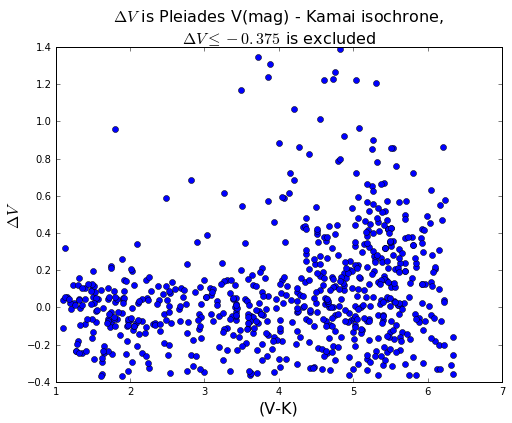

In [12]:
PleiaVK,PleiaDeltaV = PleiadesDeltaV_VK('V-K','V')

plt.figure(figsize=(8,6))
plt.plot(PleiaVK,PleiaDeltaV,'o')
plt.title('$\Delta V$ is Pleiades V(mag) - Kamai isochrone,\n$\Delta V\leq -0.375$ is excluded',fontsize=16)
plt.xlabel('(V-K)',fontsize=16)
plt.ylabel('$\Delta V$',fontsize=16)

In [13]:
def DeltaVfunc(x,y):
    '''
    General function to calculate the difference between the V vs (V-K) Kamaii isochrone and V magnitudes of data set.
    Parameters
    ----------
    x: list of floats
        (V-K) color values of data set
    y: list of floats
        V magnitudes of data set
    Returns
    -------
    DeltaV_VK: list of two lists
        (V-K) magnitudes stored in DeltaV_VK[0]
        DeltaV magnitudes stored in DeltaV_VK[1]
    '''
    KamaiIsochrone = open('data/Kamai_Isochrone.tbl','r')
    names = KamaiIsochrone.readline().split
    KamaiIsochrone.close()
    KamaiIsochrone = pd.read_table('data/Kamai_Isochrone.tbl',sep=None,engine='python')
    
    KamaiV = [i-5.67 for i in KamaiIsochrone['V']]
    KamaiVK = KamaiIsochrone['V - K']
    
    VFUNC = np.interp(x,KamaiVK,KamaiV)
    
    DeltV = []                    #Vertical separation between data V magnitudes and Kamai isochrone
    for i in range(len(y)):
        z = y[i] - VFUNC[i]
        DeltV.append(z)
    
    DeltaV_VK = list(zip(x,DeltV))
    
    return DeltaV_VK

In [14]:
Vmags = np.asarray(Vmags)
VKmags = np.asarray(VKmags)
VK = []
DeltaV = []
for i in range(len(Vmags)):
    x = DeltaVfunc(VKmags[i],Vmags[i])
    VK.append([i[0] for i in x])
    DeltaV.append([i[1] for i in x])

/Users/saethen/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


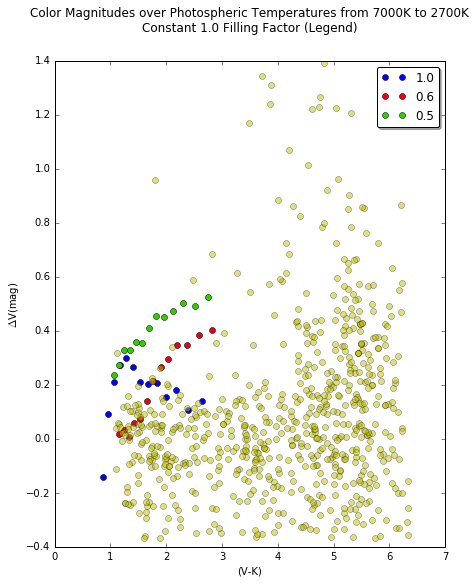

In [15]:
plt.figure(figsize=(7,10))
colormap = plt.cm.brg
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0,0.9,len(VK))])


for i in range(len(VK)):
    plt.plot(VK[i],DeltaV[i],'o')
plt.plot(PleiaVK,PleiaDeltaV,'yo',alpha=0.5)

plt.tight_layout
plt.subplots_adjust(top=0.8)

plt.legend(SpTempFrac,fancybox=True,shadow=True,loc='best')
plt.xlabel('(V-K)')
plt.ylabel('$\Delta$V(mag)')
plt.title('Color Magnitudes over Photospheric Temperatures from 7000K to 2700K\nConstant 1.0 Filling Factor (Legend)',y=1.05)